In [1]:
import pysnnblaze as pb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_threads = 1     # number of threads to use for tests

tau_m = 20e-3       # membrane time constant
C_m = 1             # membrane capacitance - unitary for simplicity
v_rest = -70e-3     # resting potential
v_reset = -70e-3    # reset potential after spike
v_thresh = -50e-3   # threshold
refractory = 5e-3   # refractory period

neuron = pb.LIFNeuron(tau_m=tau_m, C_m=C_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

## Testing a LIF Neuron
Remark that the neuron objects contain functions that manipulates an array representing the neuron states (membrane potentials in this case). However, it does not contain the state itself. 

Access to memory in unsafe with this interface, so we recommend its use only with the NeuralNetwork interface. The neuron object acts as an object for configuring a neuron type, by setting its parameters.

In [ ]:
# Testing a LIF Neuron

# Network state variables
state_arr = np.array([-70e-3], dtype=np.float64)
last_spike_arr = np.array([-1000], dtype=np.float64)
last_update_arr = np.array([0], dtype=np.float64)

print(f'State at start: {state_arr}')
print(f'Last spike time at start: {last_spike_arr}')

# Neurons receives a spike of weight 10 mV at time 0
neuron.decay(0., state_arr, last_spike_arr, last_update_arr, 1)
neuron.receive(0., 10e-3, state_arr, last_spike_arr, last_update_arr)
print(f'State after receiving spike: {state_arr}')
print(f'Last spike time after receiving spike: {last_spike_arr}')

# Update neuron state after 20 ms
neuron.decay(20e-3, state_arr, last_spike_arr, last_update_arr, 1)
print(f'State after 1 time unit: {state_arr}')
print(f'Last spike time after 1 time unit: {last_spike_arr}')

# Update neuron state to surpass threshold
neuron.decay(40e-3, state_arr, last_spike_arr, last_update_arr, 1)
neuron.receive(40e-3, 30e-3, state_arr, last_spike_arr, last_update_arr)
print(f'State after surpassing threshold: {state_arr}')
print(f'Last spike time after surpassing threshold: {last_spike_arr}')

State at start: [-0.07]
Last spike time at start: [-1000.]
State after receiving spike: [-0.06]
Last spike time after receiving spike: [-1000.]
State after 1 time unit: [-0.06632121]
Last spike time after 1 time unit: [-1000.]
State after surpassing threshold: [-0.07]
Last spike time after surpassing threshold: [0.04]


## Testing the spike monitor

In [4]:
monitor = pb.SpikeMonitor()
monitor.on_spike(0, 2)
monitor.on_spike(1, 4)
monitor.on_spike(2, 5)
monitor.spike_list

[(0.0, 2), (1.0, 4), (2.0, 5)]

## Testing a Neural Network

In [5]:
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
nn.set_num_exec_threads(num_threads)
monitor.reset_spikes()

# Spikes events with no synapses
nn.schedule_spike_event(0, 0, 100.)
nn.schedule_spike_event(2.2, 4, 100.)
nn.run(5.0)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.0, 0), (2.2, 4)]


In [6]:
# Same experiment with 2 synapses and a state monitor 
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

syn1 = pb.Synapse(0, 1, 100.0, 1.0)
syn2 = pb.Synapse(4, 2, 100.0, 1.0)

nn.add_synapse(syn1)
nn.add_synapse(syn2)

nn.schedule_spike_event(0.1, 0, 100.0)
nn.schedule_spike_event(2.2, 4, 100.0)

nn.run(10)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.1, 0), (1.1, 1), (2.2, 4), (3.2, 2)]


## Testing a network with an input neuron

In [7]:
# Initializing a network and monitors
example_net = pb.NeuralNetwork()
spike_monitor = pb.SpikeMonitor()
state_monitor = pb.StateMonitor(reading_interval=0.1e-3)
spike_monitor.reset_spikes()

lif_neuron1 = pb.LIFNeuron(tau_m=20e-3, C_m=1, v_rest=-70e-3, v_reset=-70e-3, v_thresh=-50e-3, refractory=2e-3)
lif_neuron2 = pb.LIFNeuron(tau_m=60e-3, C_m=2, v_rest=-70e-3, v_reset=-70e-3, v_thresh=-50e-3, refractory=2e-3)
inp_neuron = pb.InputNeuron()

# Adding neuron populations
example_net.add_neuron_population(1, inp_neuron)  # index 0
example_net.add_neuron_population(2, lif_neuron1) # index 1,2
example_net.add_neuron_population(1, lif_neuron2) # index 3

# Adding synapses
synapses = [
    pb.Synapse(0, 1, 10e-3, 5e-3),
    pb.Synapse(1, 2, 15e-3, 5e-3),
    pb.Synapse(2, 3, 20e-3, 5e-3),
    pb.Synapse(3, 1, 10e-3, 5e-3),
]
for syn in synapses:
    example_net.add_synapse(syn)

# Setting monitors
example_net.set_spike_monitor(spike_monitor)
example_net.set_state_monitor(state_monitor)

# Scheduling 50 spike events for input neuron
for i in range(50):
    example_net.schedule_spike_event(0.002*i, 0, 20e-3)

print(f'Network size: {example_net.size()}')

# Running the network for 200 ms
example_net.run(0.2)

Network size: 4


/tmp/ipykernel_83805/234796510.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(times, amplitudes, use_line_collection=True)


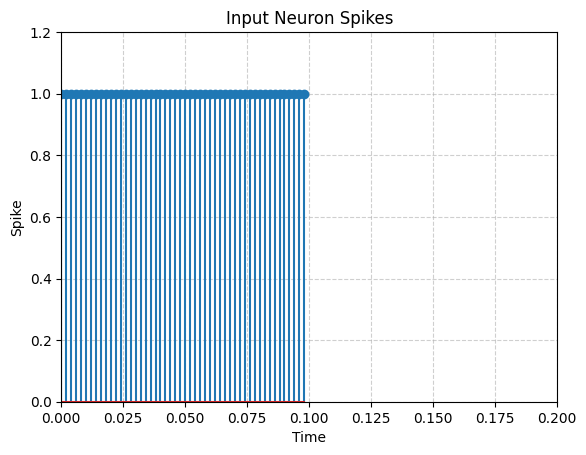

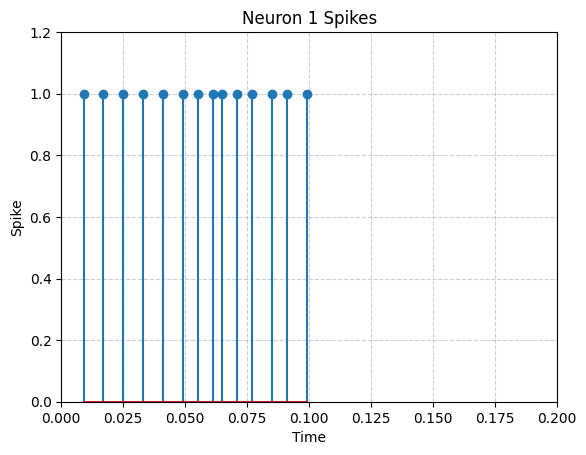

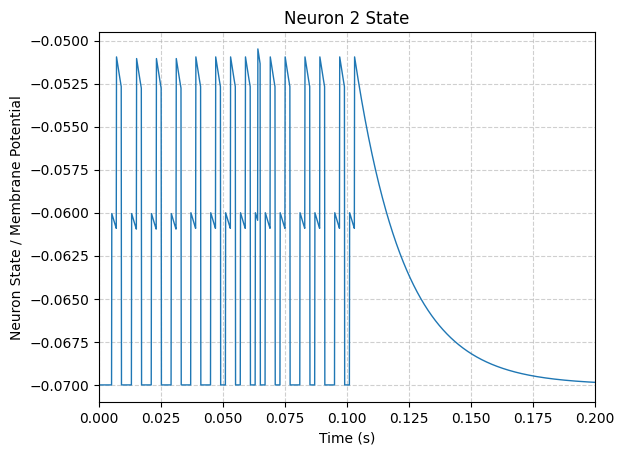

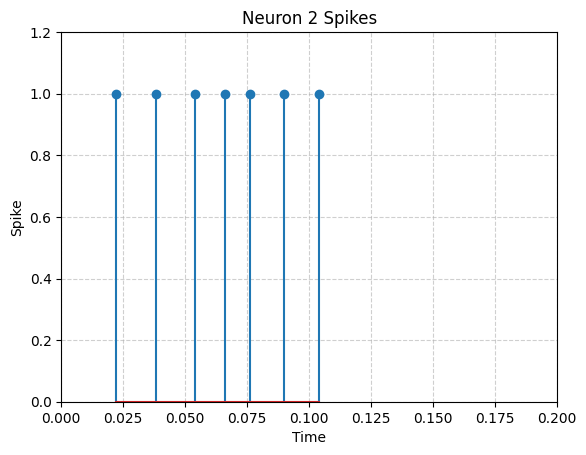

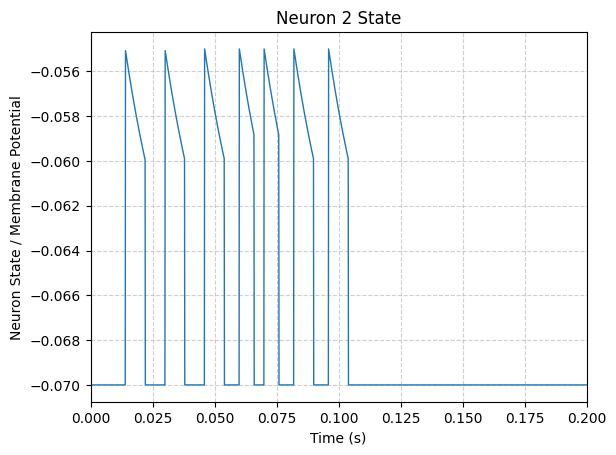

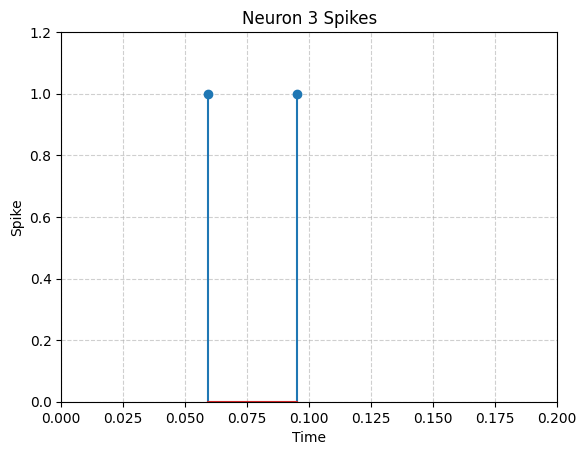

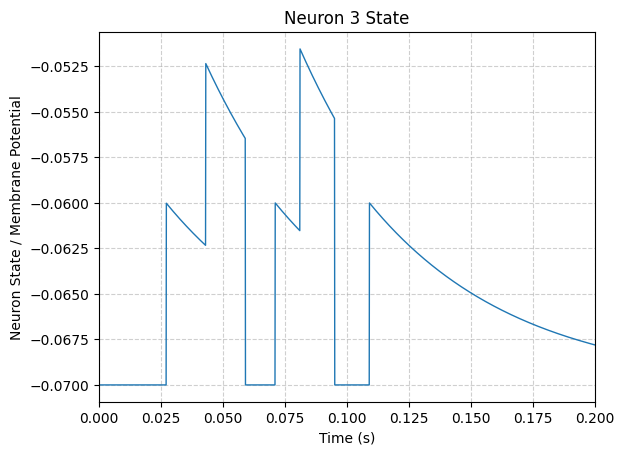

In [8]:
def plot_spikes_for_neuron(spike_events, neuron_idx, max_time, title=''):
    # Filter spike times for the specified neuron
    times = [t for t, n in spike_events if n == neuron_idx]

    if not times:
        print(f"No spikes found for neuron {neuron_idx}")
        return

    amplitudes = [1] * len(times)
    plt.stem(times, amplitudes, use_line_collection=True)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Spike")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 1.2)  # some space above spikes
    plt.xlim(0, max_time)  # some space above spikes
    plt.show()

def plot_state_for_neuron(state_events, neuron_idx, max_time, title=''):
    times = []
    values = []
    
    for t, state_vector in state_events:
        if t <= max_time:
            times.append(t)
            values.append(state_vector[neuron_idx])  # pick neuron_idx value

    if not times:
        print(f"No state data found for neuron {neuron_idx}")
        return

    plt.plot(times, values, linewidth=1)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron State / Membrane Potential")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, max_time)
    plt.show()

run_time = 0.2

plot_spikes_for_neuron(spike_monitor.spike_list, neuron_idx=0, max_time=run_time, title='Input Neuron Spikes')

plot_spikes_for_neuron(spike_monitor.spike_list, neuron_idx=1, max_time=run_time, title='Neuron 1 Spikes')
plot_state_for_neuron(state_monitor.state_vector_list, neuron_idx=1, max_time=run_time, title='Neuron 2 State')

plot_spikes_for_neuron(spike_monitor.spike_list, neuron_idx=2, max_time=run_time, title='Neuron 2 Spikes')
plot_state_for_neuron(state_monitor.state_vector_list, neuron_idx=2, max_time=run_time, title='Neuron 2 State')

plot_spikes_for_neuron(spike_monitor.spike_list, neuron_idx=3, max_time=run_time, title='Neuron 3 Spikes')
plot_state_for_neuron(state_monitor.state_vector_list, neuron_idx=3, max_time=run_time, title='Neuron 3 State')